## Music Recommendation System based on Content and Collaborative Filtering 

### Context 

Music recommendation systems are algorithms designed to suggest music to users based on their preferences, listening history, and behavior of other users on the same platform. <br>
They need sophistication in providing personalized experience and enhancing engagement on the platform. <br>

Ideal system should be able to handle - 
1. Cold Start Problem - new items or users with limited interaction history
2. Filter Bubble - reinforcing existing user preferences, lacking diversity 
3. Dynamic Preference - adapting quickly to user's evolving taste over time
4. Popularity Bias - popular items gets more popular in positive feedback loop <br>

In this notebook, we will test two approaches - <br>
1. **Collaborative Filtering** - recommending items based on other similar users behavior 


![](resized_collab_filtering.png)

2. **Content Filtering** - recommending items based on similarity of tracks to the user's listening history 

<!-- ![](content-filter.png) -->
<img src="content-filter.png" alt="Content Filter" width="20%" height="100">


### Business Questions

Sophisticated music recommendation systems are required to address various business, strategic and operational questions. Some of thema are - <br>
1. User Retention and Engagement - How can we improve user retention and keep users engaged on our platform ?
2. Content Dicsovery and Diversity - How can we help users discover new and diverse music content ?
3. Monetization strategies - What strategies can we deploy in our recommendation system to optimize revenue generation ?
4. Targeted marketing - How can we segment our user base for effective marketing ?
5. Competitive edge - How can we maintain/improvise our recommendation system to have a competitive edge in the industry ?
6. Adaptive user interface - How can we create adaptive user interfaces to enhance usability ?

### Tools and Techniques 

Content filtering, Collaborative filtering, Singular Value Decomposition (SVD), NLP, Tfidf Vectorization, Cosine similarity, Precision-at-k, Recall-at-k, Dask, sklearn, Python, Pandas, Matplotlib

### Data

The dataset used is an updated version of the **Amazon review dataset** released in 2014 (https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) <br>
This paper should be cited if this data is used in any published work - https://cseweb.ucsd.edu//~jmcauley/pdfs/emnlp19a.pdf <br>
We have used two types of data in this notebook - 
1. Meta Data - contains details about the music tracks <br>
    * Only _trackID, title, brand, rank_ and _price_ data used 
    * Will be used in Content Filtering 
2. Customer Data - contains details about the users-tracks-ratings data with each user having rated **at least 5 music tracks** (used for collaborative filtering) <br>
    * Only _trackID, userID and rating data used
    * Will be used in Collaborative Filtering 


In [22]:
# Importing necessary libraries 

import pandas as pd
import numpy as np
import gzip
import json
import dask.dataframe as dd
import re
import random

# pd.options.mode.chained_assignment = None  # default='warn'

In [20]:
# Getting meta data containing information about each track 

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

metadf_org = getDF('meta_Digital_Music.json.gz')

In [21]:
metadf_org.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,Master Collection Volume One,"[B000002UEN, B000008LD5, B01J804JKE, 747403435...",,John Michael Talbot,[],"58,291 in CDs & Vinyl (","[B000002UEN, B000008LD5, 7474034352, B000008LD...","<img src=""https://images-na.ssl-images-amazon....",,,$18.99,0001377647,[],[],NaN
1,[],,[],,Hymns Collection: Hymns 1 &amp; 2,"[5558154950, B00014K5V4]",,Second Chapter of Acts,[],"93,164 in CDs & Vinyl (","[B000008KJ3, B000008KJ0, 5558154950, B000UN8KZ...","<img src=""https://images-na.ssl-images-amazon....",,,,0001529145,[],[],NaN
2,[],,[],,Early Works - Don Francisco,"[B00004RC05, B003H8F4NA, B003ZFVHPO, B003JMP1Z...",,Don Francisco,[],"875,825 in CDs & Vinyl (","[B003H8F4NA, B003ZFVHPO, B003JMP1ZK, B00004RC0...","<img src=""https://images-na.ssl-images-amazon....",,,,0001527134,[],[],NaN
3,[],,[],,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2G...",,Keith Green,[],"203,263 in CDs & Vinyl (","[B00000I7JO, B0016CP2GS, 0001393774, B0000275Q...","<img src=""https://images-na.ssl-images-amazon....",,,$13.01,0001388703,[],[],NaN
4,[],,[1. Losing Game 2. I Can't Wait 3. Didn't He S...,,Early Works - Dallas Holm,"[B0002N4JP2, 0760131694, B00002EQ79, B00150K8J...",,Dallas Holm,[],"399,269 in CDs & Vinyl (","[B0002N4JP2, 0760131694, B00150K8JC, B003MTXNV...","<img src=""https://images-na.ssl-images-amazon....",,,,0001526146,[],[],NaN


In [25]:
# Reduce the dataframe to relevant features - trackID (asin), title, brand and price
# Will be using this throughout the notebook 

metadf = metadf_org[['asin','title','brand','price']]
metadf.dropna(inplace=True)
metadf

,asin,title,brand,price
0,0001377647,Master Collection Volume One,John Michael Talbot,$18.99
1,0001529145,Hymns Collection: Hymns 1 &amp; 2,Second Chapter of Acts,
2,0001527134,Early Works - Don Francisco,Don Francisco,
3,0001388703,So You Wanna Go Back to Egypt,Keith Green,$13.01
4,0001526146,Early Works - Dallas Holm,Dallas Holm,
...,...,...,...,...
74342,B01HH7D5KU,FUTURE PRESENTS: 56 NIGHTS,FUTURE,
74343,B01HHGQXI2,Tori Amos - Little Earthquakes? - Lp Vinyl Record,Tori Amos,
74344,B01HHRIKKK,EXO - EX'ACT 3rd Album [Korean Lucky One Versi...,EXO,
74345,B01HI2B3G2,Vanilla Fudge (Korea Edition),,


In [2]:
# Getting user-track-ratings dataframe where each user has rated at least 5 tracks

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Digital_Music_5.json.gz')

In [3]:
df = df[['overall','reviewerID','asin']]
df.rename(columns={'overall':'rating','reviewerID':'userid','asin':'asin'},inplace=True)
df = df.drop_duplicates()
df

,rating,userid,asin
0,5.0,A2TYZ821XXK2YZ,3426958910
1,5.0,A3OFSREZADFUDY,3426958910
2,5.0,A2VAMODP8M77NG,3426958910
3,4.0,AAKSLZ9IDTEH0,3426958910
4,5.0,A3OH43OZJLKI09,5557706259
...,...,...,...
169776,5.0,A1SR2T84IXOMAQ,B01HJ91MTW
169777,5.0,A2SR3DWJR1PYR6,B01HJ91MTW
169778,5.0,A24V7X30NIMOIY,B01HJ91MTW
169779,5.0,A1LW10GYP2EYM1,B01HJ91MTW


In [4]:
# Choosing 2000 users from above dataframe for proof of concept and reducing computational overheads
# Note that each user has listened to multiple tracks and have given multiple ratings hence the new dataframe's size is 29155 X 3

user_ids_to_use = df.userid.unique()[0:2000]
df = df[df.userid.isin(user_ids_to_use)]
df

,rating,userid,asin
1,5.0,A3OFSREZADFUDY,3426958910
2,5.0,A2VAMODP8M77NG,3426958910
3,4.0,AAKSLZ9IDTEH0,3426958910
4,5.0,A3OH43OZJLKI09,5557706259
5,4.0,A6JP9YYJCK3WO,5557706259
...,...,...,...
169743,5.0,A3K0KS34MKAEL,B01HEIQ1JE
169747,5.0,A3K0KS34MKAEL,B01HEIPV22
169758,5.0,AZMI3KBZHKI2P,B01HFCKRA8
169759,5.0,AWG2O9C42XW5G,B01HGB5USC


## [A] Collaborative Filtering

In [ ]:
# Creating a pivoted dataframe of dataframe 'df' with users in rows and music tracks in columns, filled with ratings from 0-5
# This is required format to perform matrix factorization later
# Note we are using dask dataframe to perform memory efficient operations 
# Dask is a parallel computing library that allows for distributed and parallel computing on larger-than-memory datasets. 

import dask.dataframe as dd

unique_column_values = df['asin'].unique()

df['asin'] = df['asin'].astype('category')
df['userid'] = df['userid'].astype('category')

dtypes = {'rating': 'object', 'userid': 'object', 'asin': 'float64'}

# Convert to Dask DataFrame
dask_df = dd.from_pandas(df, npartitions=10)

# Now try the pivot operation
pivot_df = dask_df.pivot_table(index='userid', columns='asin', values='rating', aggfunc='mean').compute()

pivot_df.columns = unique_column_values

# pivot_df.to_csv('pivot_table_2000_unique_core5k.csv')

In [27]:
# Filling Nan values to 0 representing no rating

pivot_df.fillna(0,inplace=True)
pivot_df

,3426958910,5557706259,5559166928,7799420340,9714721180,B000002TTH,B000006045,B00000747R,B000007UVW,B00000I7LP,...,B01ES9LBGA,B01EU2TOCS,B01F96A568,B01FRF0VNS,B01G33M032,B01G841RCG,B01GL0OLHU,B01H3TPVDQ,B01HEIQ1JE,B01HFCKRA8
userid,,,,,,,,,,,,,,,,,,,,,
A1049BXR3MAWT4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A108SSM7YMMTOM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DNCYK7YISHU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10FRUJV17R7TG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10GX7U2KREVF7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZRBA81ZG2PER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZSMWVBYUGMLS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVNV38G3FHUJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Sparse representations help reduce the memory footprint 
# Checking sparsity of the above pivot table 
# > 99 sparsity is desirable

def check_sparsity(matrix):
    total_elements = matrix.size
    zero_elements = np.count_nonzero(matrix == 0)
    sparsity_ratio = zero_elements / total_elements
    return sparsity_ratio

# Example
sparsity_ratio = check_sparsity(pivot_df)
print(f"Sparsity Ratio: {sparsity_ratio}")

# Define a threshold for considering a matrix as sparse, for example 0.7
is_sparse = sparsity_ratio > 0.7
print(f"Is the matrix sparse? {is_sparse}")

Sparsity Ratio: 0.9983658795286332
Is the matrix sparse? True


### Matrix Factorization

Performing Singlular Value Decomposition (SVD) on _pivot_df_ to generate ratings predictions for '0' values in the dataframe. <br>
These values are based on the behavior of other users with similar taste of music history <br>

In [445]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(pivot_df, k=50)  # k is the number of latent factors
user_predicted_ratings = np.dot(np.dot(U, np.diag(sigma)), Vt)

# Convert to DataFrame for easier handling

preds_df = pd.DataFrame(user_predicted_ratings, columns=pivot_df.columns, index=pivot_df.index)
preds_df

,3426958910,5557706259,5559166928,7799420340,9714721180,B000002TTH,B000006045,B00000747R,B000007UVW,B00000I7LP,...,B01ES9LBGA,B01EU2TOCS,B01F96A568,B01FRF0VNS,B01G33M032,B01G841RCG,B01GL0OLHU,B01H3TPVDQ,B01HEIQ1JE,B01HFCKRA8
userid,,,,,,,,,,,,,,,,,,,,,
A1049BXR3MAWT4,5.924397e-05,-4.706328e-05,0.000108,-0.002005,-0.063590,0.002855,0.011236,-0.000415,0.000529,-0.000984,...,-0.002432,-0.000703,-0.000576,-0.001726,0.000137,0.000986,-0.000478,0.000780,-0.000374,0.000341
A108SSM7YMMTOM,6.179379e-07,-7.492101e-05,-0.000485,0.002902,0.022407,-0.000695,-0.018244,0.001153,-0.001051,-0.002526,...,-0.005411,0.000359,0.000076,-0.002021,-0.000327,0.000265,-0.000430,0.000710,0.000177,0.000407
A10DNCYK7YISHU,2.055306e-05,-9.737054e-07,0.000013,0.000411,0.011190,0.000377,0.008653,0.000542,0.000243,0.001012,...,0.000556,0.000123,0.000022,-0.000279,-0.000031,0.000568,-0.000054,-0.000156,0.000016,0.000008
A10FRUJV17R7TG,-8.978274e-04,-1.626856e-03,-0.012767,0.022611,0.082249,0.004903,-0.221249,-0.013154,-0.007881,-0.028034,...,0.063539,0.004041,0.002062,0.045152,0.001758,0.010564,0.003382,0.012647,-0.001900,0.000451
A10GX7U2KREVF7,-7.455220e-05,-6.088753e-05,-0.000052,0.001413,0.177904,-0.001667,-0.035258,-0.002131,-0.001680,-0.006061,...,-0.001749,0.001235,0.000250,-0.005300,-0.000060,-0.000752,-0.001259,0.004110,-0.000858,-0.000366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZRBA81ZG2PER,-2.678299e-06,1.772102e-04,0.002079,-0.001593,-0.058017,-0.000871,0.007015,-0.003169,0.000846,-0.001614,...,-0.008575,-0.001383,-0.000923,0.015239,0.000030,-0.002875,0.004753,0.002633,-0.000042,-0.000031
AZSMWVBYUGMLS,-1.015090e-03,3.444627e-04,-0.000711,-0.005300,0.074275,-0.002571,-0.066380,-0.007320,-0.003725,0.078362,...,0.021237,-0.002688,-0.000949,0.003982,0.000408,-0.000848,-0.000233,-0.007801,-0.002353,-0.001193
AZVNV38G3FHUJ,-1.525139e-04,3.479670e-04,0.001187,0.002188,0.040999,0.000843,-0.012926,-0.002699,-0.000810,-0.000272,...,-0.008497,0.000381,0.000067,-0.002754,0.000074,0.002280,-0.001099,0.000122,-0.000292,0.000166


In [446]:
# SVD could lead to values outside input range due to the nature of matrix factorization
# Clipping values to sensible range of input values - 0 - 5 

preds_df = (preds_df.clip(lower=0, upper=5))/5 # dividing it 5 to bring it to a scale of 0-1
preds_df

,3426958910,5557706259,5559166928,7799420340,9714721180,B000002TTH,B000006045,B00000747R,B000007UVW,B00000I7LP,...,B01ES9LBGA,B01EU2TOCS,B01F96A568,B01FRF0VNS,B01G33M032,B01G841RCG,B01GL0OLHU,B01H3TPVDQ,B01HEIQ1JE,B01HFCKRA8
userid,,,,,,,,,,,,,,,,,,,,,
A1049BXR3MAWT4,1.184879e-05,0.000000,0.000022,0.000000,0.000000,0.000571,0.002247,0.000000,0.000106,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000027,0.000197,0.000000,0.000156,0.000000,0.000068
A108SSM7YMMTOM,1.235876e-07,0.000000,0.000000,0.000580,0.004481,0.000000,0.000000,0.000231,0.000000,0.000000,...,0.000000,0.000072,0.000015,0.000000,0.000000,0.000053,0.000000,0.000142,0.000035,0.000081
A10DNCYK7YISHU,4.110612e-06,0.000000,0.000003,0.000082,0.002238,0.000075,0.001731,0.000108,0.000049,0.000202,...,0.000111,0.000025,0.000004,0.000000,0.000000,0.000114,0.000000,0.000000,0.000003,0.000002
A10FRUJV17R7TG,0.000000e+00,0.000000,0.000000,0.004522,0.016450,0.000981,0.000000,0.000000,0.000000,0.000000,...,0.012708,0.000808,0.000412,0.009030,0.000352,0.002113,0.000676,0.002529,0.000000,0.000090
A10GX7U2KREVF7,0.000000e+00,0.000000,0.000000,0.000283,0.035581,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000247,0.000050,0.000000,0.000000,0.000000,0.000000,0.000822,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZRBA81ZG2PER,0.000000e+00,0.000035,0.000416,0.000000,0.000000,0.000000,0.001403,0.000000,0.000169,0.000000,...,0.000000,0.000000,0.000000,0.003048,0.000006,0.000000,0.000951,0.000527,0.000000,0.000000
AZSMWVBYUGMLS,0.000000e+00,0.000069,0.000000,0.000000,0.014855,0.000000,0.000000,0.000000,0.000000,0.015672,...,0.004247,0.000000,0.000000,0.000796,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000
AZVNV38G3FHUJ,0.000000e+00,0.000070,0.000237,0.000438,0.008200,0.000169,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000076,0.000013,0.000000,0.000015,0.000456,0.000000,0.000024,0.000000,0.000033


### Evaluating performance of collaborative filtering 

In [447]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userid', 'asin', 'rating']], reader)

# SVD (Singular Value Decomposition) is a popular matrix factorization algorithm used in recommender systems.
# Creates an instance of the SVD algorithm

svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5813  0.5836  0.5716  0.5750  0.6115  0.5846  0.0141  
MAE (testset)     0.3569  0.3611  0.3536  0.3563  0.3647  0.3585  0.0039  
Fit time          1.24    1.30    1.24    1.26    1.25    1.26    0.02    
Test time         0.04    0.03    0.03    0.03    0.03    0.03    0.00    


{'test_rmse': array([0.58133062, 0.5835674 , 0.57163407, 0.57501284, 0.61154256]),
 'test_mae': array([0.35687693, 0.36113384, 0.35357349, 0.35625439, 0.36465089]),
 'fit_time': (1.239516019821167,
  1.3049201965332031,
  1.240825891494751,
  1.2558350563049316,
  1.2546608448028564),
 'test_time': (0.03546404838562012,
  0.029695987701416016,
  0.02953815460205078,
  0.029875993728637695,
  0.030061006546020508)}

In [467]:
# Function to create train and test split

def create_train_test(ratings, test_size=0.05, seed=123):
    random.seed(seed)
    test_set = ratings.copy()  
    test_set[test_set != 0] = 0  # Initialize the test set with 0s

    train_set = ratings.copy()
    
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=int(test_size * ratings[user, :].nonzero()[0].size), 
                                        replace=False)
        train_set[user, test_ratings] = 0
        test_set[user, test_ratings] = ratings[user, test_ratings]
    
    # Ensure that train set and test set are truly disjoint
    assert(np.all((train_set * test_set) == 0))

    return train_set, test_set

# Convert pivot_df to numpy array if it's a DataFrame
ratings = pivot_df.to_numpy()

# Create train and test set
train_set, test_set = create_train_test(ratings, test_size=0.05)

# Convert them back to DataFrame if necessary
train_df = pd.DataFrame(train_set, index=pivot_df.index, columns=pivot_df.columns)
test_df = pd.DataFrame(test_set, index=pivot_df.index, columns=pivot_df.columns)


In [516]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # Apply SVD
# U, sigma, Vt = svds(train_df, k=200)  # k is the number of latent factors
# user_predicted_ratings = np.dot(np.dot(U, np.diag(sigma)), Vt)

# # Function to calculate RMSE
# def rmse(prediction, ground_truth):
#     prediction = prediction[ground_truth.nonzero()].flatten() 
#     ground_truth = ground_truth[ground_truth.nonzero()].flatten()
#     return sqrt(mean_squared_error(prediction, ground_truth))

# # Evaluate performance
# test_user_predicted_ratings = np.dot(np.dot(U, np.diag(sigma)), Vt)  # Predict ratings for test set
# rmse_value = rmse(test_user_predicted_ratings, test_df.values)  # Replace 'test_set.values' with your test set values

# print(f"RMSE: {rmse_value}")


### NOTE - 
* the mean RMSE across 5 folds is 0.5846, with a standard deviation of 0.0141
* This suggests that the model's predictions are on average about 0.8733 units away from the actual ratings (on scale of 1-5)
* This indicates decent performance of collaborative filtering 
* However, performance metrics are not always sufficient 
* Metrics such as _diversity_ or _novelty_ that are important for customer satisfaction 
* User feedback brings valuable outputs in terms of business value. 
* This is why A/B testing should be always performed

## [B] Content-based Filtering

In [428]:
# Checking unique track IDs in meta data and user-rating-tracks data 

print(len(metadf.asin.unique()))
print(len(df.merge(metadf,on='asin',how='inner').asin.unique()))

66013
112


In [501]:
# We only have meta-data available for 112 tracks out of 8912 in the pivot table, though metadata of 66013 unique tracks are available
# Note that we chose ONLY 2000 unique users in dataframe 'df' in the beginning for computational simplicity, using full data might increase this number
# Reducing metadata dataframe to only the relevant 112 tracks 

track_ids_relevant = df.merge(metadf,on='asin',how='inner').asin.unique()
metadf_reduced = metadf[metadf.asin.isin(track_ids_relevant)]
metadf_reduced.drop_duplicates(subset=['asin'], inplace=True)
metadf_reduced

/Users/yashakaushal/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,asin,title,brand,price
343,3426958910,Slayer - Greatest Hits 2 CD Set,Slayer,
456,5557505946,Something to Say,Matthew West,
463,5557706259,The Altar and the Door,Casting Crowns,$16.98
510,5559166928,He Touched Me: The Gospel Music of Elvis Presley,Elvis Presley,$19.84
569,7799420340,Essential,Michael Jackson,
...,...,...,...,...
72984,B01B6X0QC6,Prince: HITnRUN Phase Two,Prince,$3.46
73105,B01BKYPCIY,This Is What The Truth Feels Like,Gwen Stefani,$19.99
73590,B01E7N9R9A,Egomaniac,KONGOS,$2.69
73763,B01FF8ZZK6,20Ten,Prince,$37.95


### Feature Engineering for Content-Based Filtering

In [502]:
# Replace NaN with empty strings
metadf_reduced.fillna('', inplace=True)

# Function to clean text
def clean_text(text):
    # Remove HTML entities
    text = re.sub(r'&[a-z]+;', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lower case
    return text.lower()

# Clean textual columns
metadf_reduced['title'] = metadf_reduced['title'].apply(clean_text)
metadf_reduced['brand'] = metadf_reduced['brand'].apply(clean_text)

# Extract and clean numerical data

# Price
def clean_price(price):
    try:
        return float(re.sub('[^\d.]', '', price))
    except ValueError:
        return None  # or any other value you prefer for non-numeric entries

metadf_reduced['price'] = metadf_reduced['price'].apply(clean_price)

# Replace NaN with empty strings
metadf_reduced.fillna('', inplace=True)

# Ready for TF-IDF Vectorization
text_data = metadf_reduced['title'] + ' ' + metadf_reduced['brand']

metadf_reduced['clean_text'] = text_data

text_data

/Users/yashakaushal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/yashakaushal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yashakaushal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

343                  slayer  greatest hits 2 cd set slayer
456                          something to say matthew west
463                  the altar and the door casting crowns
510      he touched me the gospel music of elvis presle...
569                              essential michael jackson
                               ...                        
72984                      prince hitnrun phase two prince
73105       this is what the truth feels like gwen stefani
73590                                     egomaniac kongos
73763                                         20ten prince
73946                      meliora by ghost 20150504 ghost
Length: 112, dtype: object

In [506]:
# Checking the values in 'price' column
print(metadf_reduced.shape)
print(metadf_reduced[metadf_reduced.price==''].shape)

# Reseting the indices to a sequence from 0-111, used later
metadf_reduced = metadf_reduced.reset_index(drop=True)
metadf_reduced

(112, 5)
(46, 5)


,asin,title,brand,price,clean_text
0,3426958910,slayer greatest hits 2 cd set,slayer,,slayer greatest hits 2 cd set slayer
1,5557505946,something to say,matthew west,,something to say matthew west
2,5557706259,the altar and the door,casting crowns,16.98,the altar and the door casting crowns
3,5559166928,he touched me the gospel music of elvis presley,elvis presley,19.84,he touched me the gospel music of elvis presle...
4,7799420340,essential,michael jackson,,essential michael jackson
...,...,...,...,...,...
107,B01B6X0QC6,prince hitnrun phase two,prince,3.46,prince hitnrun phase two prince
108,B01BKYPCIY,this is what the truth feels like,gwen stefani,19.99,this is what the truth feels like gwen stefani
109,B01E7N9R9A,egomaniac,kongos,2.69,egomaniac kongos
110,B01FF8ZZK6,20ten,prince,37.95,20ten prince


**NOTE**- 
* Note that about half (46) of the tracks do not have _'price'_ information available. 
* We will exclude this numerical column and use _'clean_text'_ column for TfidfVector analysis

### Tfidf Vectorization and Cosine similarity matrix
We will perform tfidf vectorization on _clean_text_ column of meta_df_reduced and generate a cosine similarity matrix <br>
The similarity scores are from 0 - 1, with 1 corresponding to perfect match <br>
We will use this to get recommendations based on the cosine similarity score of 'history tracks of a user' with other tracks <br>

In [504]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
metadf_feature_matrix = tfidf_vectorizer.fit_transform(metadf_reduced['clean_text'])
content_sim = cosine_similarity(metadf_feature_matrix)
content_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

(112, 112)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

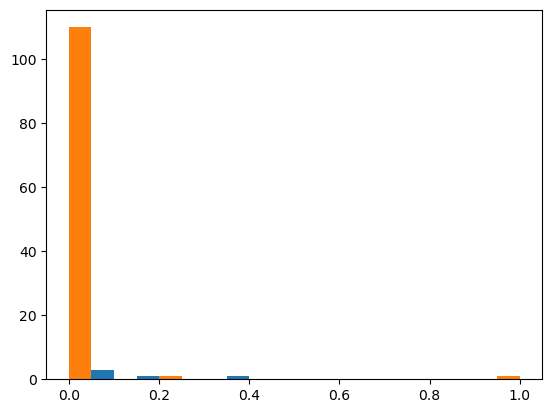

In [471]:
# Checking values for 5 tracks 
# Note only few tracks have significant similarity score, 1 represents the object with itself

print(content_sim.shape)
for i in range(2):
    plt.hist(content_sim[i],bins=20);

**NOTE** - 
* if we had more information about 'price' (or other numerical column like 'age of customer'), we would have incorporated them like below
* We could impute missing values as median value of that column OR regression value with information from other columns if only small fraction is missing
* We would then do _tfidf_ vectorization on **both** text and numerical data
* We would then generate a cosine_similarity matrix just as above
* Below code snippet summarizes this approach

In [208]:
# from sklearn.impute import SimpleImputer

# metadf_reduced['price'].replace('', np.nan, inplace=True)
# imputer = SimpleImputer(strategy='median')  # or 'mean', 'most_frequent', etc.
# metadf_reduced['price'] = imputer.fit_transform(metadf_reduced[['price']])
# metadf_reduced

# tfidf_df = pd.DataFrame(metadf_feature_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# metadf_reduced = metadf_reduced.reset_index(drop=True)
# tfidf_df_with_numerical = pd.concat([tfidf_df, metadf_reduced[['rank']]], axis=1)
# tfidf_df_with_numerical.fillna(0, inplace=True)
# tfidf_df_with_numerical.replace([np.inf, -np.inf], np.finfo('float64').max, inplace=True)
# tfidf_df_with_numerical

# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import normalize

# # Normalize the DataFrame
# normalized_tfidf_df = normalize(tfidf_df_with_numerical)

# # Compute the cosine similarity matrix
# cosine_sim_matrix = cosine_similarity(normalized_tfidf_df)
# cosine_sim_matrix

## [C] Getting both Content and Collaborative Recommendations 

In [513]:
user_ids = preds_df.index.tolist() # for collaborative filtering 
track_ids = metadf_reduced.asin.to_list() # for content filtering 

def hybrid_recommendation(user_id, history_track_ids=0):
    
    """
    Generate a hybrid recommendation for a given user and their listening track history
    """
    
    user_idx = user_ids.index(user_id)
    collaborative_score_all = preds_df[preds_df.index==user_id].values # 8912 elements, ratings on scale of 0-1 (normalized)
    top_track_names = []

    # Picking top 3 recommendations with highest collaborative score values 
    
    user_row = preds_df[preds_df.index==user_id].iloc[0] 
    top_3_track_names_collaborative = user_row.nlargest(3).index.tolist()  # 3 track IDs with highest score (also column names of preds_df)
    
    collaborative_rec = top_3_track_names_collaborative
    collaborative_score = preds_df[top_3_track_names_collaborative][preds_df.index==user_id].values # 3 values, ratings on scale of 0-1 (normalized)

    # Picking top 3 recommendations with highest content score values across all history tracks suggestions

    if history_track_ids:
        print('Ok, we got user with some history tracks!')
        track_idx_list = []
        all_content_scores = []
        top_track_scores = []

        for i in history_track_ids:
            
            if i in track_ids:
                print('yes!, we have meta data available for this history track')

                track_idx = track_ids.index(i)
                track_idx_list.append(track_idx)
                all_content_scores.append(content_sim[track_idx, :])
                
            else :
                print('Oops, we have no meta data available for this history track')

        # Extracting top 3 suggestions for every history track from content similarity (content_score)
        
        for i,j in enumerate(all_content_scores): 
            
            # Excluding the history track itself with perfect match of 1
            indices_of_top_scores = np.argsort(j)[-4:-1][::-1] 
            top_track_scores.append(content_sim[track_idx_list[i],indices_of_top_scores])
            top_track_names.append(list(metadf_reduced.loc[metadf_reduced.index.isin(indices_of_top_scores)].asin))
            
        # flattening the list as we need top 3 of all history tracks suggestions (3 suggestions from each history track)

        top_track_scores = np.array(top_track_scores)
        top_track_scores = [track for array in top_track_scores for track in array]

        top_track_names = np.array(top_track_names)
        top_track_names = [track for array in top_track_names for track in array]
        
        index_top_3_track_scores = np.argsort(top_track_scores)[::-1][:3]
        top_3_track_scores = [top_track_scores[i] for i in index_top_3_track_scores]
        top_3_track_names = [top_track_names[i] for i in index_top_3_track_scores]

        content_rec = top_3_track_names
        content_score = top_3_track_scores
                
    return collaborative_rec, collaborative_score, content_rec, content_score


In [514]:
user_id = 'ADXP05MY5KQC7'
history_track_ids = ['9714721180', 'B00A1G5VDO', 'B00AO7CE6C']

hybrid_recommendation(user_id,history_track_ids)

Ok, we got user with some history tracks!
yes!, we have meta data available for this history track
Oops, we have no meta data available for this history track
yes!, we have meta data available for this history track


(['B000006045', 'B01FENMQJU', 'B017I55TNM'],
 array([[1.        , 0.35435293, 0.31397251]]),
 ['B001GFKIBE', 'B000P56BSK', 'B0055HVX7W'],
 [0.642940690857558, 0.642940690857558, 0.6239731114911805])

In [411]:
user_id = 'AL36MFV9FIYT1'
history_track_ids = ['B000TDYO3C', 'B000V61HVE', 'B000W1XHOI']

hybrid_recommendation(user_id,history_track_ids)

Ok, we got user with some history tracks!
Oops, we have no meta data available for users track history
Oops, we have no meta data available for users track history
Oops, we have no meta data available for users track history


(['B000TDFDA0', 'B001NTLXQW', 'B000T027SO'],
 array([[0.07843753, 0.05992265, 0.04639121]]),
 [],
 [])

In [425]:
import random

user_id = random.sample(list(user_ids_to_use), 1)[0]

history_track_ids = df[df.userid==user_id].asin.to_list()[0:3]

hybrid_recommendation(user_id,history_track_ids)

Ok, we got user with some history tracks!
yes!, we have user history's meta data available
Oops, we have no meta data available for users track history
Oops, we have no meta data available for users track history


(['B000006045', 'B01FENMQJU', 'B017I55TNM'],
 array([[0.93897217, 0.30472732, 0.28315247]]),
 ['B001GFKIBE', 'B000P56BSK', 'B0055HVX7W'],
 [0.642940690857558, 0.642940690857558, 0.6239731114911805])

### Evaluating the performance of Content-based Filtering 

In [515]:
from sklearn.metrics import precision_score, recall_score

def evaluate_at_k(y_true, y_pred, k):
    precision_at_k = []
    recall_at_k = []

    for true_items, pred_items in zip(y_true, y_pred):
        true_set = set(true_items)
        pred_set = set(pred_items[:k])

        tp = len(true_set & pred_set)
        precision = tp / k
        recall = tp / len(true_set) if true_set else 0

        precision_at_k.append(precision)
        recall_at_k.append(recall)

    return np.mean(precision_at_k), np.mean(recall_at_k)

# Getting top k(3) recommendations for a user

user_id = 'ADXP05MY5KQC7'
history_used_in_prediction = df[df.userid==user_id].asin.to_list()[0:3] # 3 tracks
other_true_history = df[df.userid==user_id].asin.to_list()[3:]

_, _, content_rec, _ = hybrid_recommendation(user_id, history_used_in_prediction)

y_pred = content_rec
y_true = other_true_history

# Here are those values for the above user - 
# y_pred = ['B001GFKIBE', 'B000P56BSK','B0055HVX7W']
# y_true = ['B00L1SKW8A','B00NHXIYGE','B00SYTFYP0','B010GLWJXI','B013CKV75G','B015U2LLIW','B0181O8VO8','B01A9DL7MM','B01CTRVKM8','B01H2IVFNI','B016LS4VZE'] 

precision, recall = evaluate_at_k(y_true, y_pred, k=5)
print('')
print(f"Precision at K: {precision}, Recall at K: {recall}")


Ok, we got user with some history tracks!
yes!, we have meta data available for this history track
Oops, we have no meta data available for this history track
yes!, we have meta data available for this history track

Precision at K: 0.4666666666666666, Recall at K: 0.2804232804232804


### NOTE 
* Precision : of the top K recommendations made, what proportion is relevant or useful 
* Recall : how many of the relevant items are captured in the top K recommendations
* A precision of 0.467 implies about 46.7% of your top K (3 here) recommendations are relevant to the users
* In practical terms, if you recommended 10 items (assuming K=10), about 4 to 5 of those recommendations are expected to be relevant or of interest to the user
* A recall of 0.280 meand this model is able to capture about 28% of the relevant items in its top K recommendations.
* There is always a trade-off in precision and recall
* Fine tuning depends on the specific use-case and real-time user feedback loop could help
